In [6]:
from __future__ import annotations
import numpy as np
import os
from matplotlib import pyplot as plt

In [55]:
def get_all_file_names_in_a_folder(path_to_get_files_from: str) -> list:
    """
    Gets a list of all files in a folder

    :param path_to_get_files_from: Folder where to find files
    :return: List of names of files (not paths to them, only names)
    """

    file_names = [f for f in os.listdir(path_to_get_files_from) if os.path.isfile(os.path.join(path_to_get_files_from, f))]
    if '.DS_Store' in file_names:
        file_names.remove('.DS_Store')  # Sometimes these get in the way, so try to remove this file
    return file_names

def load_output_data(config_file_location: str, output_folder_location: str) -> dict:
    with open(config_file_location) as fp:
        line = fp.readline()
        while line:
            if len(line) > 1:
                fields = line.strip().split()
                field_name = fields[0].lower()
                if field_name == "output_folder":
                    output_folder_og = fields[2]
                if field_name == "linemask_file_folder_location":
                    linemask_file_og = fields[2]
                if field_name == "segment_file_folder_location":
                    segment_file_og = fields[2]
                if field_name == "spec_input_path":
                    spec_input_path = fields[2]
                    #if obs_location is not None:
                    #    spec_input_path = obs_location
                if field_name == "fitlist_input_folder":
                    fitlist_input_folder = fields[2]
                if field_name == "atmosphere_type":
                    atmosphere_type = fields[2]
                if field_name == "mode":
                    fitting_mode = fields[2].lower()
                if field_name == "include_molecules":
                    include_molecules = fields[2]
                if field_name == "nlte":
                    nlte_flag = fields[2].lower()
                    if nlte_flag == "true":
                        nlte_flag = True
                    else:
                        nlte_flag = False
                if field_name == "fit_microturb":  # Yes No Input
                    fit_microturb = fields[2]
                if field_name == "fit_macroturb":  # Yes No Input
                    if fields[2].lower() == "yes":
                        fit_macroturb = True
                    else:
                        fit_macroturb = False
                    if fields[2].lower() == "input":
                        input_macro = True
                    else:
                        input_macro = False
                if field_name == "fit_rotation":
                    if fields[2].lower() == "yes":
                        fit_rotation = True
                    else:
                        fit_rotation = False
                if field_name == "element":
                    elements_to_fit = []
                    for i in range(len(fields) - 2):
                        elements_to_fit.append(fields[2 + i])
                    elem_to_fit = np.asarray(elements_to_fit)
                    if "Fe" in elements_to_fit:
                        fit_met = True
                    else:
                        fit_met = False
                    nelement = len(elem_to_fit)
                if field_name == "linemask_file":
                    linemask_file = fields[2]
                if field_name == "wavelength_minimum":
                    lmin = float(fields[2])
                if field_name == "wavelength_maximum":
                    lmax = float(fields[2])
                if field_name == "wavelength_delta":
                    ldelta = float(fields[2])
                if field_name == "resolution":
                    resolution = float(fields[2])
                if field_name == "macroturbulence":
                    macroturb_input = float(fields[2])
                if field_name == "rotation":
                    rotation = float(fields[2])
                if field_name == "input_file":
                    fitlist = fields[2]
                if field_name == "output_file":
                    output = fields[2]
            line = fp.readline()
    output_data = np.loadtxt(os.path.join(output_folder_location, output), dtype=str)

    if fitting_mode != "lbl":
        ValueError("Non-lbl fitting methods are not supported yet")

    output_elem_column = f"Fe_H"

    for i in range(nelement):
        # Spectra.elem_to_fit[i] = element name
        elem_name = elem_to_fit[i]
        if elem_name != "Fe":
            output_elem_column += f"\t{elem_name}_Fe"

    names = f"#specname\twave_center\twave_start\twave_end\tDoppler_Shift_add_to_RV\t{output_elem_column}\tMicroturb\tMacroturb\trotation\tchi_squared\tew"
    output_results = {}
    output_results["specname"] = output_data[:, 0]
    output_results["wave_center"] = output_data[:, 1].astype(float)
    output_results["Doppler_Shift_add_to_RV"] = output_data[:, 4].astype(float)

    filenames_output_folder: list[str] = get_all_file_names_in_a_folder(output_folder_location)

    filenames_output_folder_convolved = []
    for filename in filenames_output_folder:
        if "_convolved.spec" in filename:
            filenames_output_folder_convolved.append(os.path.join(output_folder_location, filename))

    specname_fitlist = np.loadtxt(os.path.join(fitlist_input_folder, fitlist), dtype=str, unpack=True, usecols=(0))
    rv_fitlist = np.loadtxt(os.path.join(fitlist_input_folder, fitlist), dtype=float, unpack=True, usecols=(1))
    #if specname_fitlist.ndim == 1:
    #    specname_fitlist = np.array([specname_fitlist])
    #    rv_fitlist = np.array([rv_fitlist])

    config_dict = {}
    config_dict["filenames_output_folder"]: list[dir] = filenames_output_folder_convolved
    config_dict["linemask_location"]: str = os.path.join(linemask_file_og, linemask_file)
    config_dict["observed_spectra_location"]: str = spec_input_path
    config_dict["output_results"]: dict = output_results
    config_dict["specname_fitlist"]: np.ndarray = specname_fitlist
    config_dict["rv_fitlist"]: np.ndarray = rv_fitlist
    config_dict["output_folder_location"] = output_folder_location

    return config_dict

def plot_one_star(config_dict: dict, name_of_spectra_to_plot: str):
    filenames_output_folder: list[dir] = config_dict["filenames_output_folder"]
    observed_spectra_location: str = config_dict["observed_spectra_location"]
    linemask_location: str = config_dict["linemask_location"]
    output_results: dict = config_dict["output_results"]
    specname_fitlist: np.ndarray = config_dict["specname_fitlist"]
    rv_fitlist: np.ndarray = config_dict["rv_fitlist"]

    indices_to_plot = np.where(np.char.find(filenames_output_folder, name_of_spectra_to_plot) != -1)[0]
    if len(indices_to_plot) > 1:
        print(f"Warning, several specnames were found with that name {name_of_spectra_to_plot}, using first one")
    if len(indices_to_plot) == 0:
        ValueError(f"Could not find {name_of_spectra_to_plot} in the spectra to plot")

    index_to_plot = indices_to_plot[0]
    #if index_to_plot > len(filenames_output_folder) or index_to_plot < 0:
    #    ValueError(f"Use a valid index_to_plot that refers to the index in filenames_output_folder, got index of {index_to_plot}; length of filenames_output_folder is {len(filenames_output_folder)}")

    output_results_specname = output_results["specname"]
    output_results_wave_center = output_results["wave_center"]
    output_results_dopplershift = output_results["Doppler_Shift_add_to_RV"]

    filename_fitted_spectra = filenames_output_folder[index_to_plot]
    filename_observed_spectra = filename_fitted_spectra.replace("result_spectrum_", "").replace("_convolved.spec", "").replace(config_dict["output_folder_location"], "")

    output_results_correct_specname_indices = np.where(output_results_specname == filename_observed_spectra)[0]

    print(filename_observed_spectra)
    #print(specname_fitlist)
    rv_index = np.where(specname_fitlist == filename_observed_spectra)[0][0]
    rv = rv_fitlist[rv_index]

    wavelength, flux = np.loadtxt(filename_fitted_spectra, dtype=float, unpack=True)  # normalised flux fitted
    wavelength_observed, flux_observed = np.loadtxt(os.path.join(observed_spectra_location, filename_observed_spectra), dtype=float, unpack=True) # normalised flux observed
    linemask_center_wavelengths, linemask_left_wavelengths, linemask_right_wavelengths = np.loadtxt(linemask_location, dtype=float, comments=";", usecols=(0, 1, 2), unpack=True)

    if linemask_center_wavelengths.size > 1:
        linemask_center_wavelengths = np.array(sorted(linemask_center_wavelengths))
        linemask_left_wavelengths = np.array(sorted(linemask_left_wavelengths))
        linemask_right_wavelengths = np.array(sorted(linemask_right_wavelengths))
    elif linemask_center_wavelengths.size == 1:
        linemask_center_wavelengths = np.array([linemask_center_wavelengths])
        linemask_left_wavelengths = np.array([linemask_left_wavelengths])
        linemask_right_wavelengths = np.array([linemask_right_wavelengths])

    for linemask_center_wavelength, linemask_left_wavelength, linemask_right_wavelength in zip(linemask_center_wavelengths, linemask_left_wavelengths, linemask_right_wavelengths):
        #print(output_results_wave_center[output_results_correct_specname_indices])
        output_result_index_to_plot = (np.abs(output_results_wave_center[output_results_correct_specname_indices] - linemask_center_wavelength)).argmin()
        fitted_rv = output_results_dopplershift[output_results_correct_specname_indices][output_result_index_to_plot]

        doppler = fitted_rv + rv
        wavelength_observed_rv = wavelength_observed / (1 + (doppler / 299792.))

        plt.plot(wavelength, flux, color='red')
        plt.scatter(wavelength_observed_rv, flux_observed, color='black', marker='o', linewidths=0.5)
        plt.xlim(linemask_left_wavelength - 0.3, linemask_right_wavelength + 0.3)
        plt.ylim(0, 1.05)
        plt.plot([linemask_left_wavelength, linemask_left_wavelength], [0, 2], color='green', alpha=0.2)
        plt.plot([linemask_right_wavelength, linemask_right_wavelength], [0, 2], color='green', alpha=0.2)
        plt.plot([linemask_center_wavelength, linemask_center_wavelength], [0, 2], color='grey', alpha=0.35)
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Normalised flux")
        plt.show()
        plt.close()


In [56]:
# CHANGE NEXT TWO LINES
configuration_file_location: str = "../input_files/tsfitpy_input_configuration_ba_oliver_y_nlte_fenlte.txt"
output_folder_location: str = "../output_files/Mar-27-2023-14-11-24_0.23697863971919042_y_nlte_fe_nlte_oliverba/"

config_dict = load_output_data(configuration_file_location, output_folder_location)

00000302-6002570_spectrum.txt


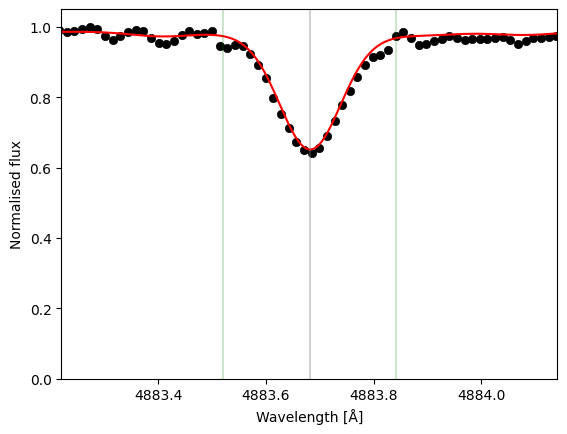

In [57]:
# CHANGE NEXT LINE
star_name_to_plot: str = "302-600"

plot_one_star(config_dict, star_name_to_plot)